In [2]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import json
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [3]:
BASE_DIR = '../3d-object-detection-for-autonomous-vehicles/'

# Check train.csv

In [4]:
train = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train.head()

,Id,PredictionString
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...


In [5]:
train.isna().sum()

Id                  0
PredictionString    0
dtype: int64

In [6]:
train['PredictionString'][0]

'2680.2830359778527 698.1969292852777 -18.04776692365821 2.064 5.488 2.053 2.6041643845397946 car 2691.997461646401 660.8016536569899 -18.674258695658377 1.818 4.57 1.608 -0.33517602468486984 car 2713.6075009338388 694.4034809694599 -18.589971933264334 1.779 4.992 1.62 2.579455758321168 car 2679.986916931015 706.9101495091695 -18.349594424165822 1.798 3.903 1.722 2.5861656766206993 car 2659.352095715659 719.4174623706303 -18.442998898501283 1.936 4.427 1.921 2.601798964714126 car 2705.199576267366 687.6053718669459 -18.13608710950738 1.849 4.586 1.801 2.6187666817281556 car 2712.706309822551 690.895857094069 -18.43179693610965 1.848 4.829 1.528 2.571936879901208 car 2755.5551865955817 646.2995181065994 -18.04141609089024 2.003 5.109 1.875 -0.5583518579067484 car 2721.868054568993 685.1596225679214 -17.64155351660436 2.539 7.671 3.287 2.609719767554756 truck 2723.602359479293 680.1666687198758 -17.298964332024624 2.557 7.637 3.594 2.598576712925146 truck 2683.980215118377 712.4764240778

In [7]:
object_columns = ['sample_id', 'object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw', 'class_name']
objects = []
for sample_id, ps in train.values[:]:
    object_params = ps.split()
    n_objects = len(object_params)
    for i in range(n_objects // 8):
        x, y, z, w, l, h, yaw, c = tuple(object_params[i * 8: (i + 1) * 8])
        objects.append([sample_id, i, x, y, z, w, l, h, yaw, c])
train_objects = pd.DataFrame(objects, columns=object_columns)

In [8]:
numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
train_objects[numerical_cols] = np.float32(train_objects[numerical_cols].values)
train_objects.head()

,sample_id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0.0,2680.282959,698.196899,-18.047768,2.064,5.488,2.053,2.604164,car
1,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,1.0,2691.997559,660.801636,-18.674259,1.818,4.570,1.608,-0.335176,car
2,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2.0,2713.607422,694.403503,-18.589972,1.779,4.992,1.620,2.579456,car
3,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,3.0,2679.986816,706.910156,-18.349594,1.798,3.903,1.722,2.586166,car
4,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,4.0,2659.352051,719.417480,-18.442999,1.936,4.427,1.921,2.601799,car


# Rendering Train Image

In [9]:
sample_data_path = os.path.join(BASE_DIR, 'train_data', 'sample_data.json')

with open(sample_data_path, 'r') as f:
    data = json.load(f)
sample_id_to_filename = {
    x['sample_token']: x['filename'].split('/')[1] for x in data
}
sample_filename = sample_id_to_filename[train_objects['sample_id'].values[0]]
print(sample_filename)

host-a101_cam6_1242144892450000006.jpeg


In [10]:
class_names = train_objects['class_name'].unique()
print(class_names)

['car' 'truck' 'other_vehicle' 'bus' 'pedestrian' 'bicycle' 'motorcycle'
 'emergency_vehicle' 'animal']


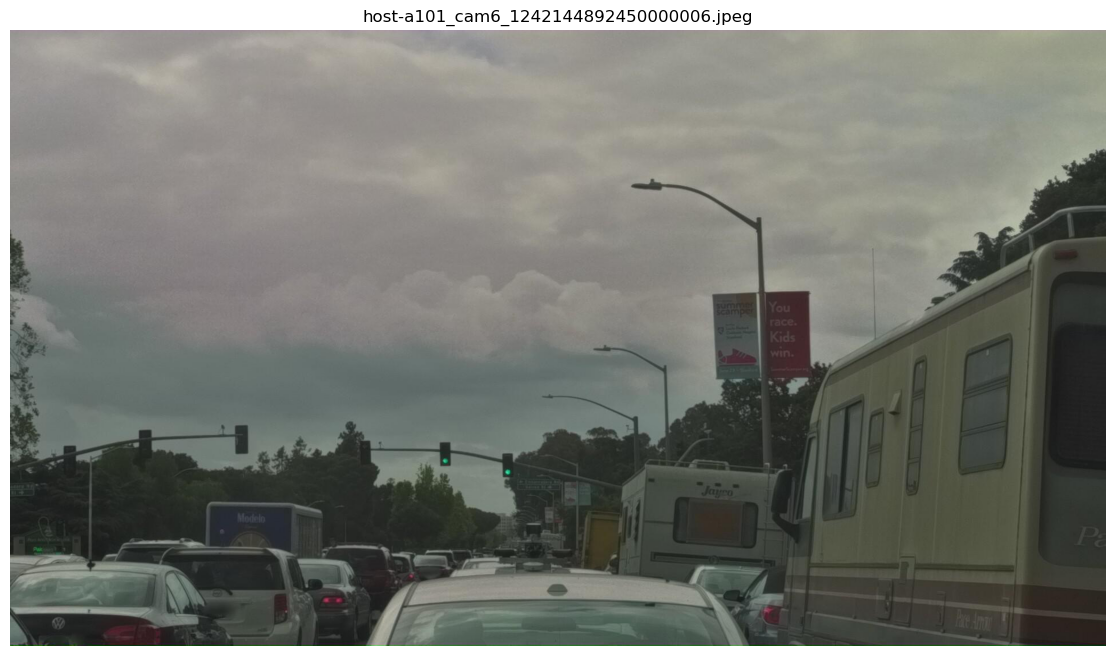

In [11]:
def image_rendering(file_path):
    image = cv2.imread(os.path.join(BASE_DIR, 'train_images', file_path))
    if image is None:
        raise ValueError("이미지를 로드할 수 없습니다. 경로를 확인하세요.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 8))
    plt.imshow(image)
    plt.title(file_path)
    plt.axis('off')
    plt.show()

image_rendering(sample_id_to_filename[train_objects['sample_id'].values[0]])